In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [17]:
import pm4py
import pandas as pd
from pm4py.objects.log.util import dataframe_utils

# 1. 读取原始 XES 日志（完整事件日志）
log = pm4py.read_xes('C:/Users/Jingyi/Desktop/MA/data/BPI_Challenge_2012.xes.gz')

# 2. 转换为 DataFrame（包含所有事件）
df_full = pm4py.convert_to_dataframe(log)

# 3. 预处理（可选：标准化列名/排序）
# 有些列类型/时区可能需要规范化
# df_full = dataframe_utils.convert_timestamp_columns_in_df(df_full)

# 4. 统计原始活动分布
print('=== 原始日志统计（未过滤）===')
print(f"总事件数: {len(df_full)}")
print(f"唯一案例数: {df_full['case:concept:name'].nunique()}")
print(f"唯一活动数: {df_full['concept:name'].nunique()}")
print('示例活动（前20个）:', df_full['concept:name'].unique()[:20])

# 5. 按前缀查看不同类型活动（A_, O_, W_, T_ etc.）
prefix_groups = (
    df_full.assign(prefix=df_full['concept:name'].str.extract(r'^(\w+?_?)'))
           .groupby('prefix')['concept:name']
           .nunique()
           .sort_values(ascending=False)
)
print('\n按前缀统计不同类别的活动数:')
print(prefix_groups)

# 6. 生成一个仅包含“工作项”(Work items) 的子集（即原来你之前用的 W_ 且 COMPLETE）
df_w_complete = df_full[
    df_full['concept:name'].str.startswith('W_') &
    (df_full['lifecycle:transition'] == 'COMPLETE')
].copy()

print('\n=== W_ & COMPLETE 子集统计 ===')
print(f"事件数: {len(df_w_complete)}")
print(f"案例数: {df_w_complete['case:concept:name'].nunique()}")
print(f"活动数: {df_w_complete['concept:name'].nunique()}")

# 7. 如果你需要一个“融合”数据集（例如只保留 COMPLETE 的事件，不限前缀）
df_complete_all = df_full[df_full['lifecycle:transition'] == 'COMPLETE'].copy()
print('\n=== 所有 COMPLETE 事件统计（不限前缀）===')
print(f"事件数: {len(df_complete_all)}  活动数: {df_complete_all['concept:name'].nunique()}")

# 8. 统一重命名列，生成标准格式（保留全部活动版本 + W_ 版本）
rename_map = {
    'case:concept:name': 'case_id',
    'concept:name': 'activity',
    'time:timestamp': 'timestamp',
    'lifecycle:transition': 'transition',
    'org:resource': 'org:resource'
}
# 全量 COMPLETE 版本
all_std = df_complete_all.rename(columns=rename_map)
all_std = all_std[['case_id','activity','timestamp','transition','org:resource']].dropna(subset=['case_id','activity'])
# 仅 W_ COMPLETE 版本
w_std = df_w_complete.rename(columns=rename_map)
w_std = w_std[['case_id','activity','timestamp','transition','org:resource']].dropna(subset=['case_id','activity'])

# 9. 保存不同版本，以便你灵活选择
all_std.to_csv('BPI12_ALL_COMPLETE.csv', index=False)
w_std.to_csv('BPI12W_COMPLETE.csv', index=False)
print('\n已保存:')
print('  BPI12_ALL_COMPLETE.csv  (所有前缀，transition=COMPLETE)')
print('  BPI12W_COMPLETE.csv     (仅 W_ 工作项 COMPLETE)')

# 10. 如果后续想要包含其他生命周期状态，可调整过滤条件，例如：
# df_variant = df_full[df_full['concept:name'].str.startswith(('W_','A_'))]
# 或者直接不过滤 lifecycle:transition。

# 11. 还原：如果你之前只有 W_ 是因为这段过滤：
#   df[df['concept:name'].str.startswith('W_') & (df['lifecycle:transition']=='COMPLETE')]
# 现在我们保留了全量 df_full，可用于重新派生其他子集。

c:\Softwares\anaconda3\envs\gnp\lib\site-packages\pm4py\util\dt_parsing\parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
c:\Softwares\anaconda3\envs\gnp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 13087/13087 [00:06<00:00, 1931.44it/s]



=== 原始日志统计（未过滤）===
总事件数: 262200
唯一案例数: 13087
唯一活动数: 24
示例活动（前20个）: ['A_SUBMITTED' 'A_PARTLYSUBMITTED' 'A_PREACCEPTED'
 'W_Completeren aanvraag' 'A_ACCEPTED' 'O_SELECTED' 'A_FINALIZED'
 'O_CREATED' 'O_SENT' 'W_Nabellen offertes' 'O_SENT_BACK'
 'W_Valideren aanvraag' 'A_REGISTERED' 'A_APPROVED' 'O_ACCEPTED'
 'A_ACTIVATED' 'O_CANCELLED' 'W_Wijzigen contractgegevens' 'A_DECLINED'
 'A_CANCELLED']

按前缀统计不同类别的活动数:
prefix
A_    10
O_     7
W_     7
Name: concept:name, dtype: int64

=== W_ & COMPLETE 子集统计 ===
事件数: 72413
案例数: 9658
活动数: 6

=== 所有 COMPLETE 事件统计（不限前缀）===
事件数: 164506  活动数: 23

按前缀统计不同类别的活动数:
prefix
A_    10
O_     7
W_     7
Name: concept:name, dtype: int64

=== W_ & COMPLETE 子集统计 ===
事件数: 72413
案例数: 9658
活动数: 6

=== 所有 COMPLETE 事件统计（不限前缀）===
事件数: 164506  活动数: 23

已保存:
  BPI12_ALL_COMPLETE.csv  (所有前缀，transition=COMPLETE)
  BPI12W_COMPLETE.csv     (仅 W_ 工作项 COMPLETE)

已保存:
  BPI12_ALL_COMPLETE.csv  (所有前缀，transition=COMPLETE)
  BPI12W_COMPLETE.csv     (仅 W_ 工作项 COMPLETE)


In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)  
print(torch.cuda.is_available())  

2.6.0+cu126
12.6
True


In [4]:
# C:\Users\Jingyi\.cache\huggingface\hub
# C:\Users\Jingyi\.cache\torch\transformers

In [5]:
df = pd.read_csv('C:/Users/Jingyi/Desktop/MA/data/helpdesk_processed.csv', sep=",")
df.head()

,case_id,activity,resource,timestamp
0,Case 1,assign seriousness,Value 1,2012-10-09 14:50:17
1,Case 1,take in charge ticket,Value 1,2012-10-09 14:51:01
2,Case 1,take in charge ticket,Value 2,2012-10-12 15:02:56
3,Case 1,resolve ticket,Value 1,2012-10-25 11:54:26
4,Case 1,closed,Value 3,2012-11-09 12:54:39


Number of case IDs: 4580
Number of activity types: 14
Activity types:
assign seriousness
take in charge ticket
resolve ticket
closed
require upgrade
wait
insert ticket
create sw anomaly
schedule intervention
resolved
invalid
verified
resolve sw anomaly
duplicate
Case length distribution statistics:
count    4580.000000
mean        4.661135
std         1.180026
min         2.000000
25%         4.000000
50%         4.000000
75%         5.000000
max        15.000000
dtype: float64


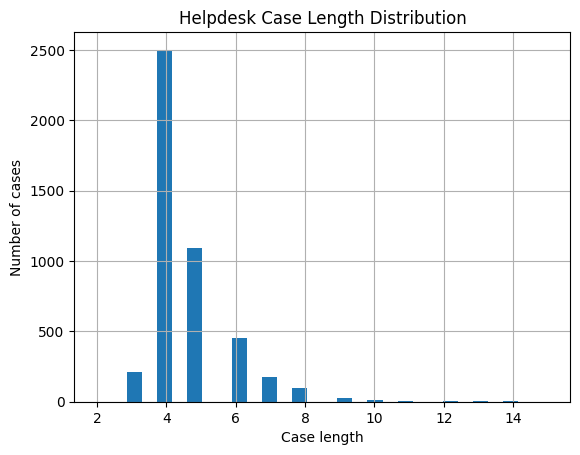

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('C:/Users/Jingyi/Desktop/MA/data/helpdesk_processed.csv', sep=",")

# 1. Number of unique case IDs
num_cases = df['case_id'].nunique()
print(f"Number of case IDs: {num_cases}")

# 2. Number of unique activities
num_activities = df['activity'].nunique()
print(f"Number of activity types: {num_activities}")

# List all unique activities
activity_list = df['activity'].unique()
print("Activity types:")
for act in activity_list:
    print(act)

# 3. Case length distribution
case_lengths = df.groupby('case_id').size()
print("Case length distribution statistics:")
print(case_lengths.describe())

# Plot the distribution of case lengths
import matplotlib.pyplot as plt
case_lengths.hist(bins=30)
plt.xlabel('Case length')
plt.ylabel('Number of cases')
plt.title('Helpdesk Case Length Distribution')
plt.show()


Number of case IDs: 42966
Number of activity types: 8
Activity types:
O_Create Offer
O_Created
O_Sent (mail and online)
O_Returned
O_Accepted
O_Cancelled
O_Refused
O_Sent (online only)
Case length distribution statistics:
count    42966.000000
mean         4.508751
std          0.560714
min          3.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
dtype: float64


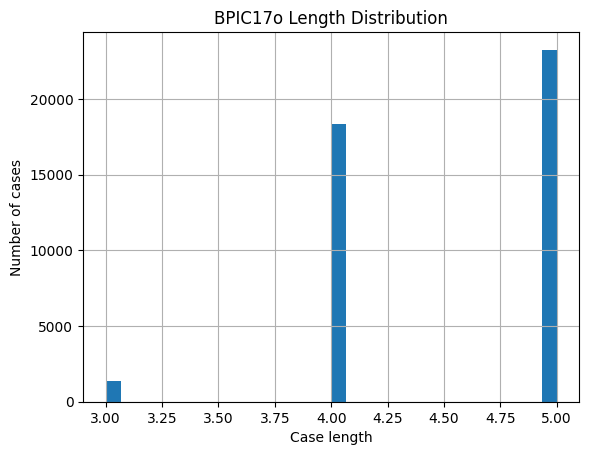

In [16]:
# Load the dataset
df = pd.read_csv('C:/Users/Jingyi/Desktop/MA/data/bpic2017_o.csv', sep=",")

# 1. Number of unique case IDs
num_cases = df['case_id'].nunique()
print(f"Number of case IDs: {num_cases}")

# 2. Number of unique activities
num_activities = df['activity'].nunique()
print(f"Number of activity types: {num_activities}")

# List all unique activities
activity_list = df['activity'].unique()
print("Activity types:")
for act in activity_list:
    print(act)

# 3. Case length distribution
case_lengths = df.groupby('case_id').size()
print("Case length distribution statistics:")
print(case_lengths.describe())

# Plot the distribution of case lengths
import matplotlib.pyplot as plt
case_lengths.hist(bins=30)
plt.xlabel('Case length')
plt.ylabel('Number of cases')
plt.title('BPIC17o Length Distribution')
plt.show()


Number of case IDs: 1050
Number of activity types: 16
Activity types:
ER Registration
Leucocytes
CRP
LacticAcid
ER Triage
ER Sepsis Triage
IV Liquid
IV Antibiotics
Admission NC
Release A
Return ER
Admission IC
Release B
Release C
Release D
Release E
Case length distribution statistics:
count    1050.000000
mean       14.489524
std        11.475941
min         3.000000
25%         9.000000
50%        13.000000
75%        16.000000
max       185.000000
dtype: float64


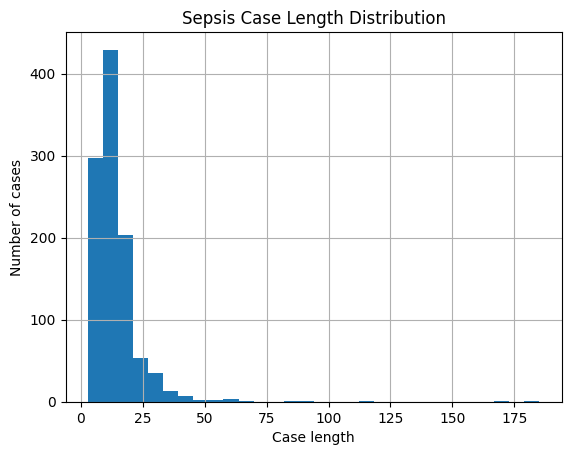

In [15]:
# Load the dataset
df = pd.read_csv('C:/Users/Jingyi/Desktop/MA/data/sepsis.csv', sep=",")

# 1. Number of unique case IDs
num_cases = df['case_id'].nunique()
print(f"Number of case IDs: {num_cases}")

# 2. Number of unique activities
num_activities = df['activity'].nunique()
print(f"Number of activity types: {num_activities}")

# List all unique activities
activity_list = df['activity'].unique()
print("Activity types:")
for act in activity_list:
    print(act)

# 3. Case length distribution
case_lengths = df.groupby('case_id').size()
print("Case length distribution statistics:")
print(case_lengths.describe())

# Plot the distribution of case lengths
import matplotlib.pyplot as plt
case_lengths.hist(bins=30)
plt.xlabel('Case length')
plt.ylabel('Number of cases')
plt.title('Sepsis Case Length Distribution')
plt.show()


Number of case IDs: 1199
Number of activity types: 289
Activity types:
register submission date request
OLO messaging active
phase application received
send confirmation receipt
start WABOprocedure
create procedure confirmation
publish
create publication document
registration date publication
create subcases completeness
procedure change
forward to the competent authority
regular procedure without MER
enter senddate acknowledgement
phase application receptive
send letter in progress
create subcases content
phase advice known
grounds for refusal
ask stakeholders views
by law
creating environmental permit decision
set decision status
decision date prior to decision
set decision phase decision permitting decided
generating decision environmental permit
phase decision taken
register objection and appeal periods
creating cover letter decision
transcript decision environmental permit to stakeholders
enter senddate decision environmental permit
start decision phase decision permitting sent
en

C:\Users\Jingyi\AppData\Local\Temp\ipykernel_22452\3255820401.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/Jingyi/Desktop/MA/data/BPIC15_1.csv', sep=",")


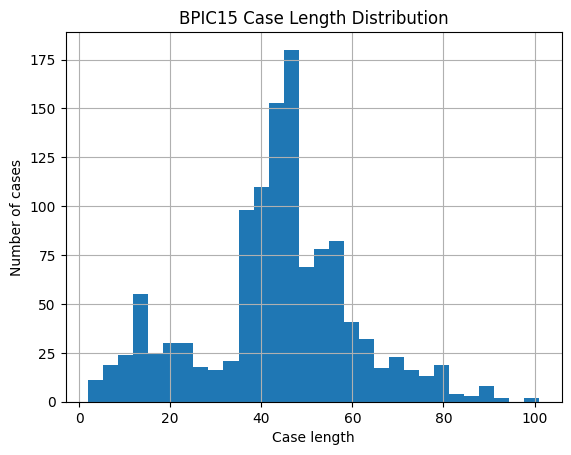

In [14]:
# Load the dataset
df = pd.read_csv('C:/Users/Jingyi/Desktop/MA/data/BPIC15_1.csv', sep=",")

# 1. Number of unique case IDs
num_cases = df['case_id'].nunique()
print(f"Number of case IDs: {num_cases}")

# 2. Number of unique activities
num_activities = df['activity'].nunique()
print(f"Number of activity types: {num_activities}")

# List all unique activities
activity_list = df['activity'].unique()
print("Activity types:")
for act in activity_list:
    print(act)

# 3. Case length distribution
case_lengths = df.groupby('case_id').size()
print("Case length distribution statistics:")
print(case_lengths.describe())

# Plot the distribution of case lengths
import matplotlib.pyplot as plt
case_lengths.hist(bins=30)
plt.xlabel('Case length')
plt.ylabel('Number of cases')
plt.title('BPIC15 Case Length Distribution')
plt.show()


Number of case IDs: 10043
Number of activity types: 15
Activity types:
Declaration SUBMITTED by EMPLOYEE
Declaration APPROVED by ADMINISTRATION
Declaration FINAL_APPROVED by SUPERVISOR
Request Payment
Payment Handled
Declaration APPROVED by BUDGET OWNER
Declaration REJECTED by ADMINISTRATION
Declaration REJECTED by EMPLOYEE
Declaration APPROVED by PRE_APPROVER
Declaration REJECTED by MISSING
Declaration REJECTED by SUPERVISOR
Declaration REJECTED by BUDGET OWNER
Declaration REJECTED by PRE_APPROVER
other
Declaration SAVED by EMPLOYEE
Case length distribution statistics:
count    10043.000000
mean         5.489396
std          1.373259
min          3.000000
25%          5.000000
50%          5.000000
75%          6.000000
max         24.000000
dtype: float64


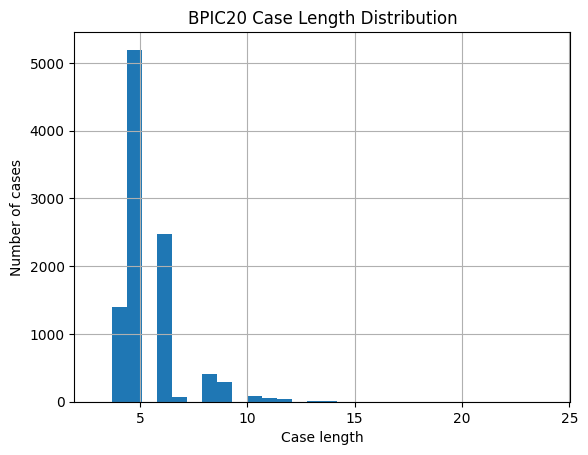

In [1]:
import pandas as pd
# Load the dataset
df = pd.read_csv('C:/Users/Jingyi/Desktop/MA/data/BPIC20_processed.csv', sep=",")

# 1. Number of unique case IDs
num_cases = df['case_id'].nunique()
print(f"Number of case IDs: {num_cases}")

# 2. Number of unique activities
num_activities = df['activity'].nunique()
print(f"Number of activity types: {num_activities}")

# List all unique activities
activity_list = df['activity'].unique()
print("Activity types:")
for act in activity_list:
    print(act)

# 3. Case length distribution
case_lengths = df.groupby('case_id').size()
print("Case length distribution statistics:")
print(case_lengths.describe())

# Plot the distribution of case lengths
import matplotlib.pyplot as plt
case_lengths.hist(bins=30)
plt.xlabel('Case length')
plt.ylabel('Number of cases')
plt.title('BPIC20 Case Length Distribution')
plt.show()

Number of case IDs: 6886
Number of activity types: 19
Activity types:
Request For Payment SUBMITTED by EMPLOYEE
Request For Payment APPROVED by ADMINISTRATION
Request For Payment APPROVED by BUDGET OWNER
Request For Payment FINAL_APPROVED by SUPERVISOR
Request Payment
Payment Handled
Request For Payment REJECTED by ADMINISTRATION
Request For Payment REJECTED by EMPLOYEE
Request For Payment APPROVED by PRE_APPROVER
Request For Payment REJECTED by SUPERVISOR
Request For Payment SAVED by EMPLOYEE
Request For Payment REJECTED by PRE_APPROVER
Request For Payment REJECTED by MISSING
Request For Payment FINAL_APPROVED by BUDGET OWNER
Request For Payment REJECTED by BUDGET OWNER
Request For Payment APPROVED by SUPERVISOR
Request For Payment FINAL_APPROVED by DIRECTOR
Request For Payment FOR_APPROVAL by SUPERVISOR
Request For Payment FOR_APPROVAL by ADMINISTRATION
Case length distribution statistics:
count    6886.000000
mean        5.343596
std         1.467491
min         1.000000
25%        

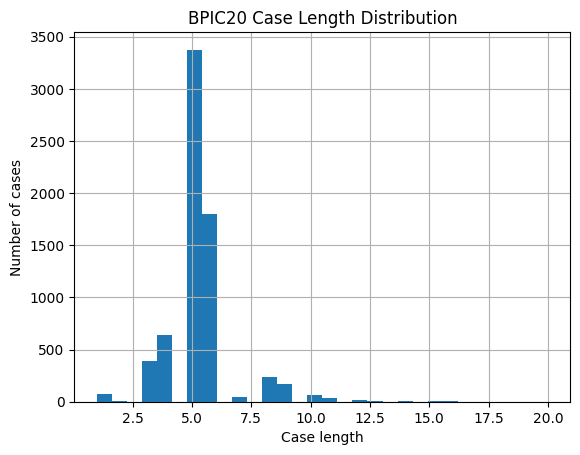

In [1]:
import pandas as pd
# Load the dataset
df = pd.read_csv('C:/Users/Jingyi/Desktop/MA/data/bpic2020.csv', sep=",")

# 1. Number of unique case IDs
num_cases = df['case_id'].nunique()
print(f"Number of case IDs: {num_cases}")

# 2. Number of unique activities
num_activities = df['activity'].nunique()
print(f"Number of activity types: {num_activities}")

# List all unique activities
activity_list = df['activity'].unique()
print("Activity types:")
for act in activity_list:
    print(act)

# 3. Case length distribution
case_lengths = df.groupby('case_id').size()
print("Case length distribution statistics:")
print(case_lengths.describe())

# Plot the distribution of case lengths
import matplotlib.pyplot as plt
case_lengths.hist(bins=30)
plt.xlabel('Case length')
plt.ylabel('Number of cases')
plt.title('BPIC20 Case Length Distribution')
plt.show()

Number of case IDs: 9658
Number of activity types: 6
Activity types:
W_Completeren aanvraag
W_Nabellen offertes
W_Valideren aanvraag
W_Afhandelen leads
W_Nabellen incomplete dossiers
W_Beoordelen fraude
Case length distribution statistics:
count    9658.000000
mean        7.497722
std         7.275539
min         1.000000
25%         2.000000
50%         6.000000
75%        11.000000
max        74.000000
dtype: float64


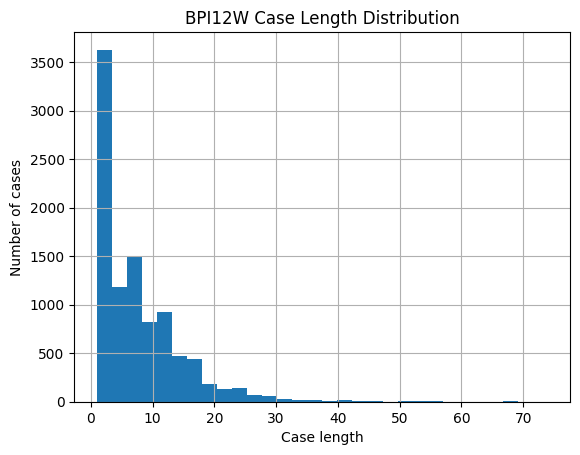

: 

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('C:/Users/Jingyi/Desktop/MA/data/BPI12W.csv', sep=",")

# 1. Number of unique case IDs
num_cases = df['case_id'].nunique()
print(f"Number of case IDs: {num_cases}")

# 2. Number of unique activities
num_activities = df['activity'].nunique()
print(f"Number of activity types: {num_activities}")

# List all unique activities
activity_list = df['activity'].unique()
print("Activity types:")
for act in activity_list:
    print(act)

# 3. Case length distribution
case_lengths = df.groupby('case_id').size()
print("Case length distribution statistics:")
print(case_lengths.describe())

# Plot the distribution of case lengths
import matplotlib.pyplot as plt
case_lengths.hist(bins=30)
plt.xlabel('Case length')
plt.ylabel('Number of cases')
plt.title('BPI12W Case Length Distribution')
plt.show()


In [3]:
import pandas as pd

df = pd.read_csv("C:/Users/Jingyi/Desktop/MA/data/BPI12W.csv", dtype=str)

rename_map = {
    "case:concept:name": "case_id",
    "concept:name": "activity",
    "time:timestamp": "timestamp",
    "lifecycle:transition": "transition",
    "org:resource": "org:resource"  # 不变
}

# 重命名
df = df.rename(columns=rename_map)

# 统一时间格式
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# 选取标准列（存在才选）
standard_cols = ["case_id", "activity", "timestamp", "transition", "org:resource"]
cols = [c for c in standard_cols if c in df.columns]
df_std = df[cols].copy()

# 可选：去除空activity或case
df_std = df_std.dropna(subset=["case_id", "activity"])

# 保存
df_std.to_csv("C:/Users/Jingyi/Desktop/MA/data/BPI12_standard.csv", index=False)
print("Saved to data/BPI12_standard.csv")

Saved to data/BPI12_standard.csv


Number of case IDs: 13087
Number of activity types: 23
Activity types:
A_SUBMITTED
A_PARTLYSUBMITTED
A_PREACCEPTED
A_ACCEPTED
O_SELECTED
A_FINALIZED
O_CREATED
O_SENT
W_Completeren aanvraag
W_Nabellen offertes
O_SENT_BACK
A_REGISTERED
A_APPROVED
O_ACCEPTED
A_ACTIVATED
W_Valideren aanvraag
O_CANCELLED
A_DECLINED
A_CANCELLED
W_Afhandelen leads
O_DECLINED
W_Nabellen incomplete dossiers
W_Beoordelen fraude
Case length distribution statistics:
count    13087.000000
mean        12.570184
std         11.347435
min          3.000000
25%          3.000000
50%          7.000000
75%         20.000000
max         96.000000
dtype: float64


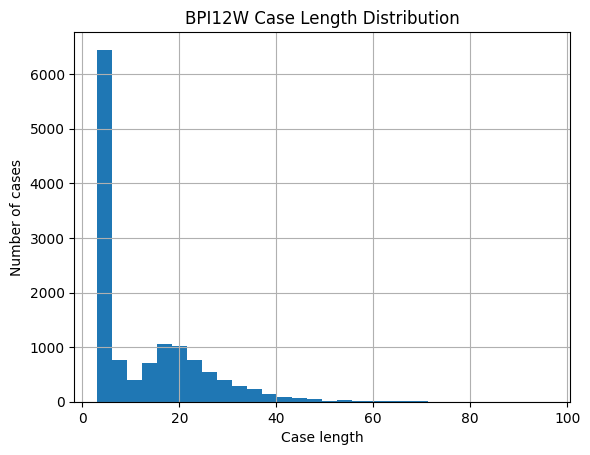

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('C:/Users/Jingyi/Desktop/MA/data/BPI12.csv', sep=",")

# 1. Number of unique case IDs
num_cases = df['case_id'].nunique()
print(f"Number of case IDs: {num_cases}")

# 2. Number of unique activities
num_activities = df['activity'].nunique()
print(f"Number of activity types: {num_activities}")

# List all unique activities
activity_list = df['activity'].unique()
print("Activity types:")
for act in activity_list:
    print(act)

# 3. Case length distribution
case_lengths = df.groupby('case_id').size()
print("Case length distribution statistics:")
print(case_lengths.describe())

# Plot the distribution of case lengths
import matplotlib.pyplot as plt
case_lengths.hist(bins=30)
plt.xlabel('Case length')
plt.ylabel('Number of cases')
plt.title('BPI12W Case Length Distribution')
plt.show()


In [2]:
import pandas as pd
import networkx as nx
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict
import os

# -------------------------
# 工具函数
# -------------------------
def sanitize_id(s):
    import re
    s2 = re.sub(r'\W+', '_', str(s))
    if s2 and s2[0].isdigit():
        s2 = 'id_' + s2
    return s2

def build_dfg(df, case_col='case_id', act_col='activity', ts_col='timestamp'):
    dfg = Counter()
    start_counts = Counter()
    end_counts = Counter()
    activity_set = set()

    df_sorted = df.sort_values(by=[case_col, ts_col])
    for case, group in df_sorted.groupby(case_col):
        acts = list(group[act_col].astype(str))
        if not acts:
            continue
        activity_set.update(acts)
        start_counts[acts[0]] += 1
        end_counts[acts[-1]] += 1
        for a, b in zip(acts, acts[1:]):
            dfg[(a, b)] += 1

    return dfg, start_counts, end_counts, activity_set

def write_bpmn_xml(output_path, dfg_counter, start_counts, end_counts, activities):
    NS = { 'bpmn': 'http://www.omg.org/spec/BPMN/20100524/MODEL' }
    ET.register_namespace('', NS['bpmn'])

    definitions = ET.Element('{%s}definitions' % NS['bpmn'],
                             attrib={'id': 'Defs_1', 'targetNamespace': 'http://example.com/bpmn'})
    process = ET.SubElement(definitions, '{%s}process' % NS['bpmn'],
                            attrib={'id': 'Process_1', 'isExecutable': 'false'})

    # Start / End
    start_id = "StartEvent_1"
    end_id = "EndEvent_1"
    ET.SubElement(process, '{%s}startEvent' % NS['bpmn'], attrib={'id': start_id, 'name': 'Start'})
    ET.SubElement(process, '{%s}endEvent' % NS['bpmn'], attrib={'id': end_id, 'name': 'End'})

    # activities -> tasks
    act_id_map = {}
    for act in sorted(activities):
        tid = "Task_" + sanitize_id(act)
        act_id_map[act] = tid
        ET.SubElement(process, '{%s}task' % NS['bpmn'], attrib={'id': tid, 'name': act})

    # helper
    seq_counter = 1
    def mk_seq(src, tgt):
        nonlocal seq_counter
        sid = f"Flow_{seq_counter}"
        seq_counter += 1
        ET.SubElement(process, '{%s}sequenceFlow' % NS['bpmn'],
                      attrib={'id': sid, 'sourceRef': src, 'targetRef': tgt})

    # successors
    succ = defaultdict(list)
    for (a,b), _ in dfg_counter.items():
        succ[a].append(b)

    # Start → first activities
    first_acts = list(start_counts.keys())
    if len(first_acts) == 1:
        mk_seq(start_id, act_id_map[first_acts[0]])
    else:
        gw = "Gateway_Start"
        ET.SubElement(process, '{%s}exclusiveGateway' % NS['bpmn'], attrib={'id': gw})
        mk_seq(start_id, gw)
        for a in first_acts:
            mk_seq(gw, act_id_map[a])

    # Each activity → successors
    for a in activities:
        a_id = act_id_map[a]
        sucs = succ[a]
        if len(sucs) == 1:
            mk_seq(a_id, act_id_map[sucs[0]])
        elif len(sucs) > 1:
            gw = f"Gateway_{sanitize_id(a)}"
            ET.SubElement(process, '{%s}exclusiveGateway' % NS['bpmn'], attrib={'id': gw})
            mk_seq(a_id, gw)
            for b in sucs:
                mk_seq(gw, act_id_map[b])

    # Last activities → End
    last_acts = list(end_counts.keys())
    if len(last_acts) == 1:
        mk_seq(act_id_map[last_acts[0]], end_id)
    else:
        gw = "Gateway_End"
        ET.SubElement(process, '{%s}exclusiveGateway' % NS['bpmn'], attrib={'id': gw})
        for a in last_acts:
            mk_seq(act_id_map[a], gw)
        mk_seq(gw, end_id)

    ET.ElementTree(definitions).write(output_path, encoding='utf-8', xml_declaration=True)
    print("✔ BPMN 文件已保存到", output_path)


# -------------------------
# 主函数（你只需要调用这个）
# -------------------------
def generate_bpmn_from_csv(csv_path):
    df = pd.read_csv(csv_path)

    required = {'case_id', 'activity', 'timestamp'}
    if not required.issubset(df.columns):
        raise ValueError(f"CSV 必须包含列: {required}，当前列: {list(df.columns)}")

    # timestamp 转 datetime
    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    except:
        pass

    dfg, start_counts, end_counts, activities = build_dfg(df)
    write_bpmn_xml("process.bpmn", dfg, start_counts, end_counts, activities)

    print("🎉 BPMN 生成完成：process.bpmn")


In [ ]:
generate_bpmn_from_csv("C:/Users/Jingyi/Desktop/MA/data/helpdesk_processed.csv")
output = generate_process_image("你的文件.csv")
from IPython.display import Image, display
display(Image(filename=output))

✔ BPMN 文件已保存到 process.bpmn
🎉 BPMN 生成完成：process.bpmn
